# Convolutional Neural Networks (CNNs)

In [13]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [8, 6]

In [20]:
from IPython.display import Image
Image(url='https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif')

Mouse V1 data from Stringer et al. (2019)
https://www.biorxiv.org/content/10.1101/679324v2.abstract

![](images/grating-mouse.png)

These data comprise time-averaged responses of ~20,000 neurons to ~4,000 stimulus gratings of different orientations from 0-360 degrees, recorded through Calcium imaging. The responses have been normalized by spontaneous levels of activity and then z-scored over stimuli, so expect negative numbers. They have also been binned and averaged to each degree of orientation.

Example from [Neuromatch Academy](https://compneuro.neuromatch.io/tutorials/W2D1_DeepLearning/student/W2D1_Tutorial1.html)

In [14]:
neural_responses = np.load('neural_responses.npy')
grating_orientations = np.load('grating_orientations.npy')

neural_responses.shape, grating_orientations.shape

((360, 23589), (360,))

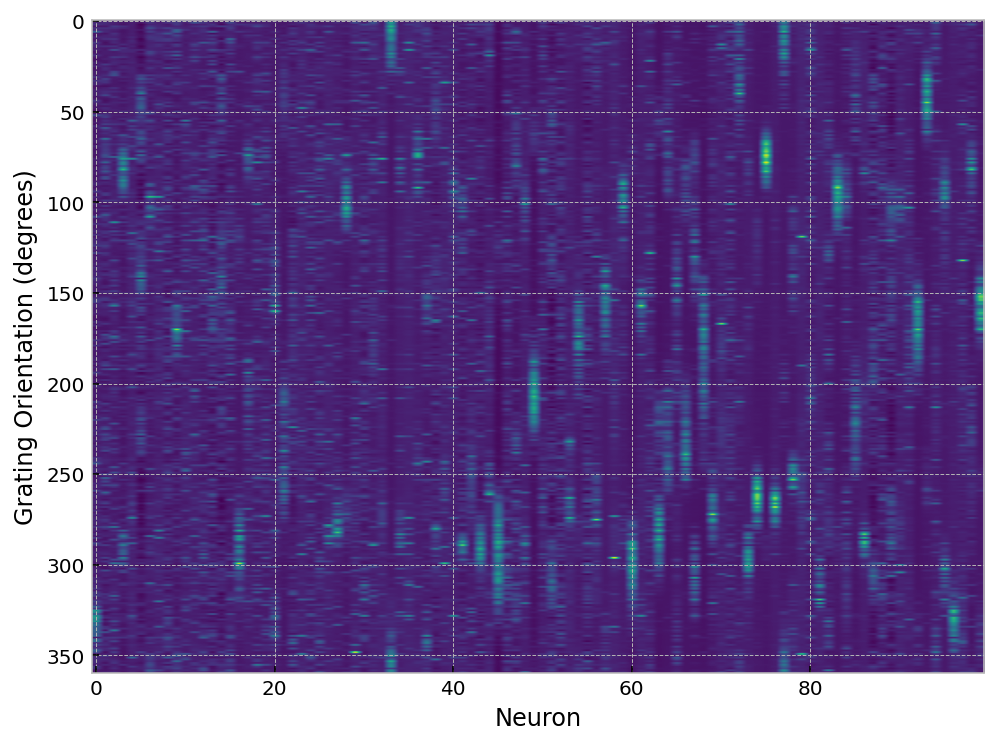

In [15]:
plt.imshow(neural_responses[:,:100], aspect='auto')
plt.xlabel('Neuron')
plt.ylabel('Grating Orientation (degrees)');

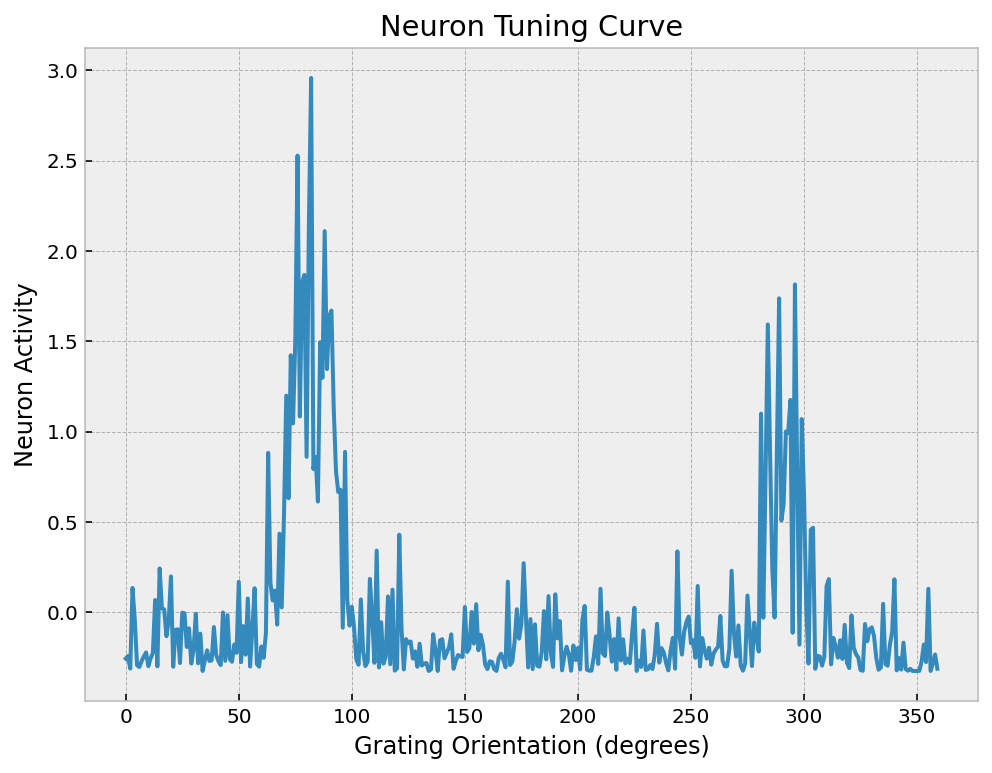

In [16]:
plt.plot(grating_orientations, neural_responses[:,3])
plt.xlabel('Grating Orientation (degrees)')
plt.ylabel('Neuron Activity')
plt.title('Neuron Tuning Curve');

In [17]:
# adapted from https://compneuro.neuromatch.io/tutorials/W2D1_DeepLearning/student/W2D1_Tutorial2.html#helper-functions
def make_filters(out_channels=6, K=7):
    """ make example filters, some center-surround and gabors
    Returns:
      filters: out_channels x K x K
    """
    grid = np.linspace(-K/2, K/2, K).astype(np.float32)
    xx,yy = np.meshgrid(grid, grid, indexing='ij')

    # create center-surround filters
    sigma = 1.1
    gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*sigma**2))
    wide_gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*2)**2))
    center_surround = gaussian - 0.5 * wide_gaussian

    # create gabor filters
    thetas = np.linspace(0, 180, out_channels-2+1)[:-1] * np.pi/180
    gabors = np.zeros((len(thetas), K, K), np.float32)
    lam = 10
    phi = np.pi/2
    gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*0.4)**2))
    for i,theta in enumerate(thetas):
        x = xx*np.cos(theta) + yy*np.sin(theta)
        gabors[i] = gaussian * np.cos(2*np.pi*x/lam + phi)

    filters = np.concatenate((center_surround[np.newaxis,:,:],
                            -1*center_surround[np.newaxis,:,:],
                            gabors),
                           axis=0)
    filters /= np.abs(filters).max(axis=(1,2))[:,np.newaxis,np.newaxis]
    filters -= filters.mean(axis=(1,2))[:,np.newaxis,np.newaxis]
    # convert to torch
    filters = torch.from_numpy(filters)
    # add channel axis
    filters = filters.unsqueeze(1)

    return filters

In [18]:
filters = make_filters(out_channels=6, K=7)

filters.shape

torch.Size([6, 1, 7, 7])

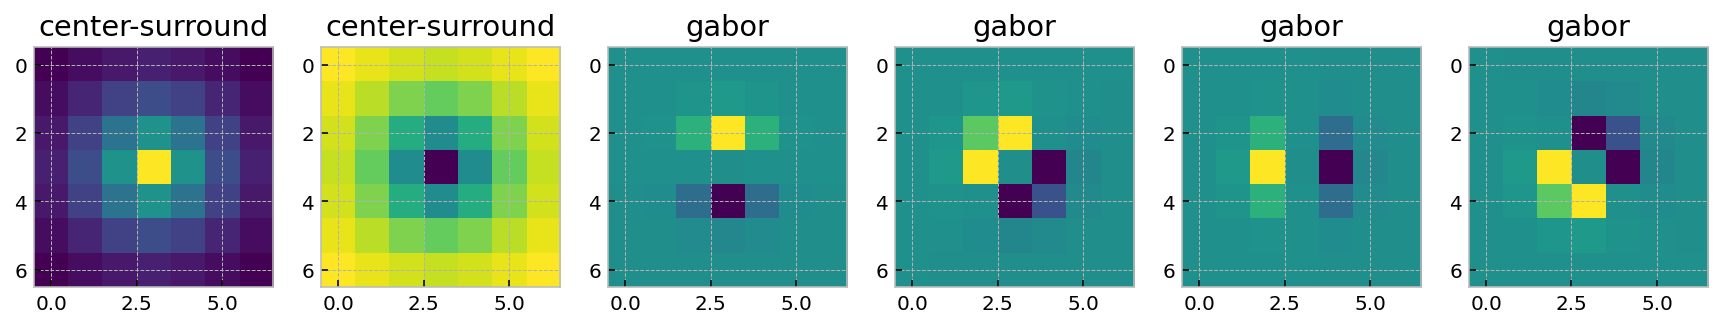

In [25]:
plt.figure(figsize=[15,4])
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(filters[i,0,:,:])
    if i < 2:
        plt.title('center-surround')
    else:
        plt.title('gabor')

In [21]:
# adapted from https://compneuro.neuromatch.io/tutorials/W2D1_DeepLearning/student/W2D1_Tutorial2.html#helper-functions
def make_grating(angle, sf=1 / 28, res=0.1, patch=False):
    """Generate oriented grating stimulus

    Args:
    angle (float): orientation of grating (angle from vertical), in degrees
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.

    Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

    """

    angle = np.deg2rad(angle)  # transform to radians

    wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0

    xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)

    if patch:
        gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
        gratings[gratings < 0] = 0
        gratings[gratings > 0] = 1
        xcent = gratings.shape[1] * .75
        ycent = gratings.shape[0] / 2
        xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
        icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
        gratings[~icirc] = 0.5
    else:
        gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
        gratings[gratings < 0] = 0
        gratings[gratings > 0] = 1

    gratings -= 0.5

    # Return torch tensor
    return torch.tensor(gratings, dtype=torch.float32)

Stimuli

![](images/grating-orientations.png)

In [26]:
orientations = [-90, -45, 0, 45, 90]
stimuli = torch.zeros((len(orientations), 1, 48, 64), dtype=torch.float32)
for i, ori in enumerate(orientations):
    stimuli[i,0,:,:] = make_grating(ori)

stimuli.shape, filters.shape

(torch.Size([5, 1, 48, 64]), torch.Size([6, 1, 7, 7]))

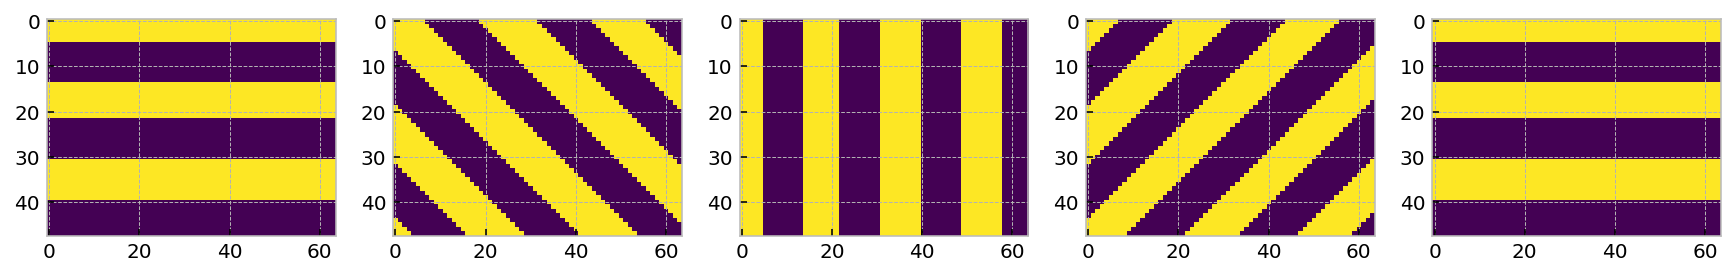

In [27]:
plt.figure(figsize=[15,5])
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(stimuli[i,0,:,:])

In [28]:
orientations = np.arange(360)
stimuli = torch.zeros((len(orientations), 1, 48, 64), dtype=torch.float32)
for i, ori in enumerate(orientations):
    stimuli[i,0,:,:] = make_grating(ori)

stimuli.shape, filters.shape

(torch.Size([360, 1, 48, 64]), torch.Size([6, 1, 7, 7]))

Try this convolutional neural network...

![](images/conv-fc-net.png)

In [37]:
class GratingLeftRightTiltNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # convolutional layer
        # add padding to ensure that each channel has same dimensionality as input
        self.conv = nn.Conv2d(1, 6, kernel_size=7, padding=3)
        
        # init convolutional kernels to center-surround and gabor filters
        self.conv.weight = nn.Parameter(filters)
        self.conv.bias = nn.Parameter(torch.zeros((6,), dtype=torch.float32))
        
        # fully connected layer with 10 neurons
        self.fc = nn.Linear(6 * 48 * 64, 10)
        
        # output layer with single neuron (will decide left or right tilt)
        self.out = nn.Linear(10, 1)

    def forward(self, images_in):
        # images_in:  n_stimuli x 1  x h x w
        # images_out: n_stimuli x 1 x h x w
        images_out = self.conv(images_in)
        
        # each row of X is the flattened output from the convolutional layer
        # for one stimulus image
        X = images_out.reshape(-1, 6 * 48 * 64)
        
        # h: length 10 output of fully connected layer
        X = torch.relu(self.fc(X))
        
        # network output with sigmoid for binary choice
        y = torch.sigmoid(self.out(X))
        
        return y

In [54]:
torch.manual_seed(1)
model = GratingLeftRightTiltNet()

output = model(stimuli)

output.shape

torch.Size([360, 1])

In [55]:
output = output.squeeze().detach().numpy()
choice = (output >= 0.5)

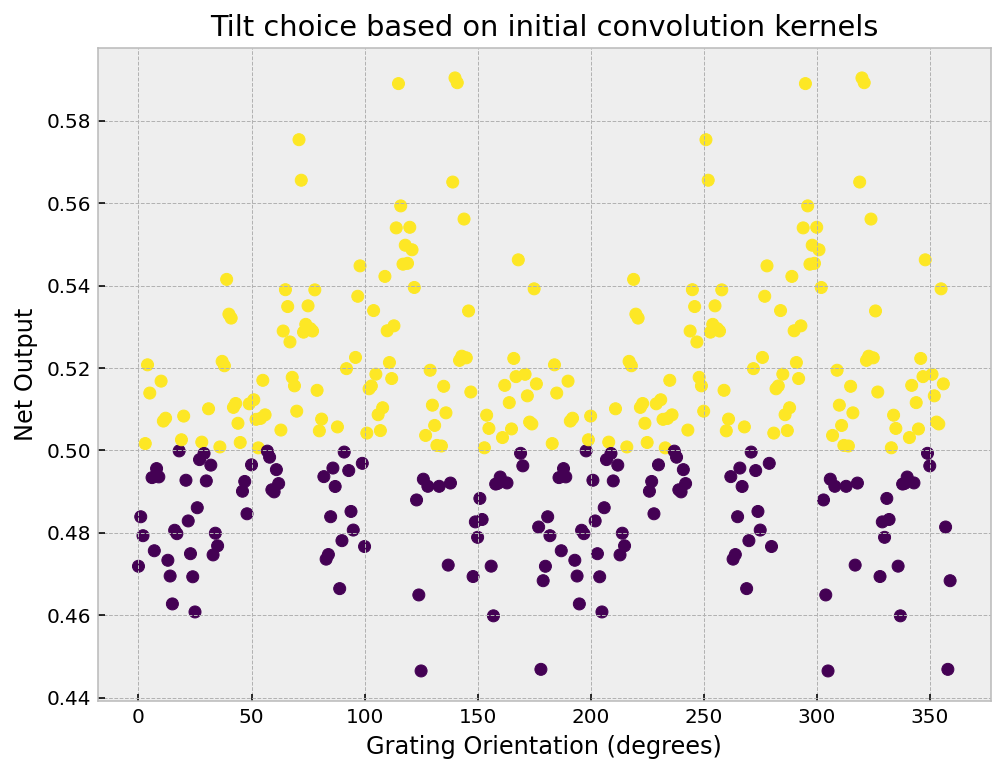

In [56]:
plt.scatter(range(360), output, c=choice)
plt.xlabel('Grating Orientation (degrees)')
plt.ylabel('Net Output')
plt.title('Tilt choice based on initial convolution kernels');

In [61]:
# loss function
loss_fn = nn.MSELoss()

# stochastic gradient descent optimizer
# lr = learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [62]:
def train(model, X, y, loss_fn, optimizer, n_epochs):
    # put model into training mode
    model.train()
    
    train_loss = np.zeros(n_epochs)
    for i in range(n_epochs):
        # Compute prediction error
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # update model parameters (i.e., weights and biases)
        optimizer.step()
        
        # store loss
        train_loss[i] = loss.item()
    
    return train_loss

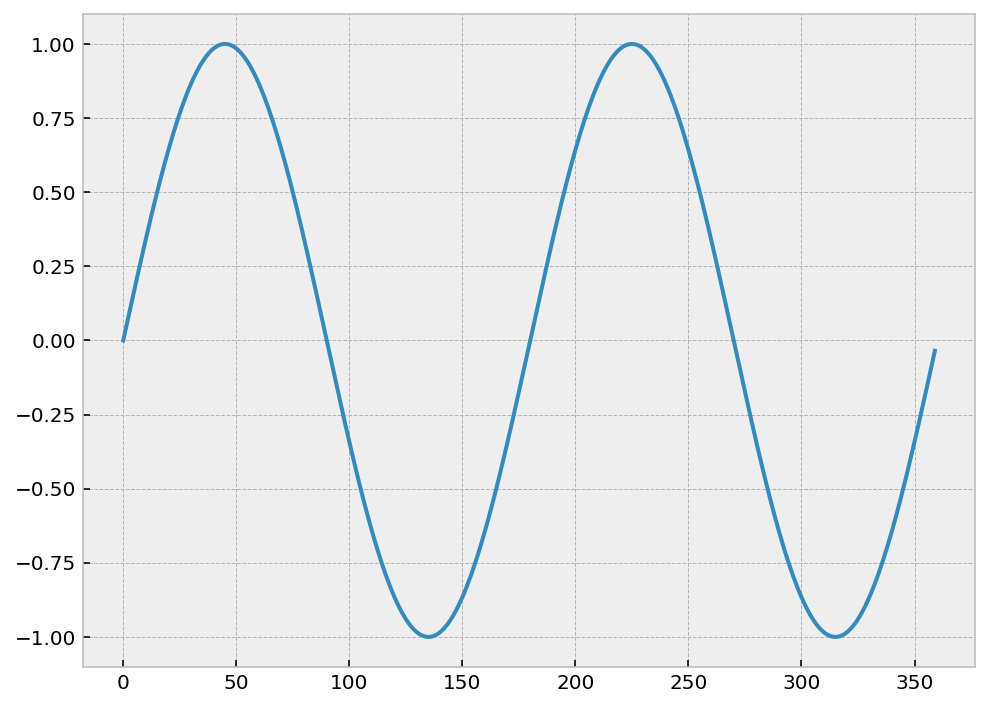

In [73]:
orientations = np.arange(360)
y = np.sin(orientations * np.pi / 180 * 2)

plt.plot(np.arange(360), y);

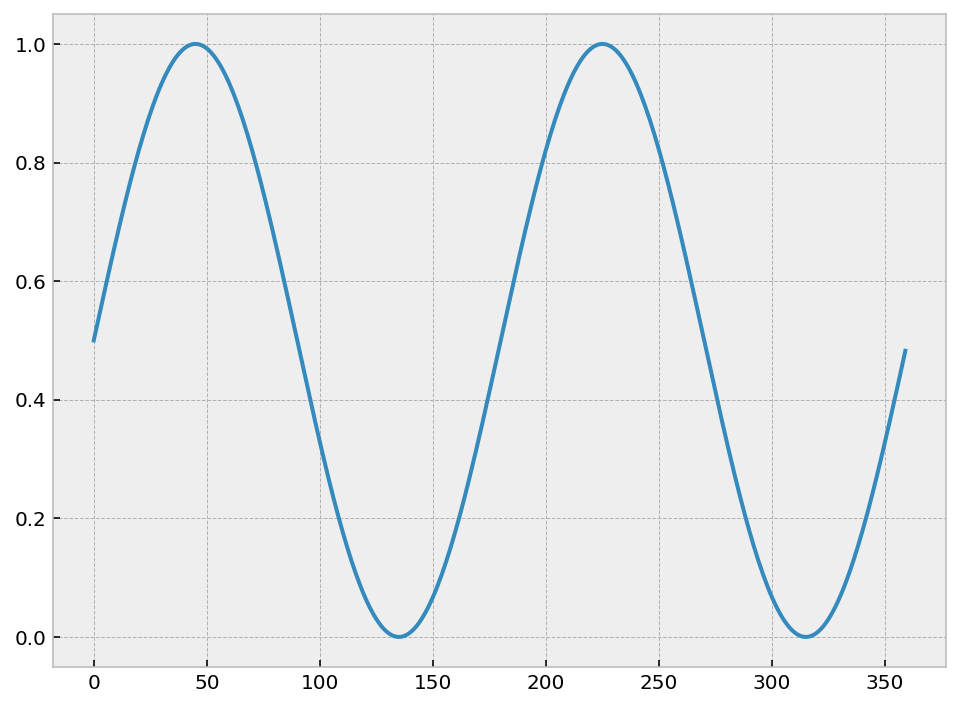

In [74]:
y = y / 2 + 0.5

plt.plot(np.arange(360), y);

In [75]:
y = torch.tensor(y.reshape(-1,1)).float()

stimuli.shape, y.shape

(torch.Size([360, 1, 48, 64]), torch.Size([360, 1]))

In [76]:
train_loss = train(model, stimuli, y, loss_fn, optimizer, 300)

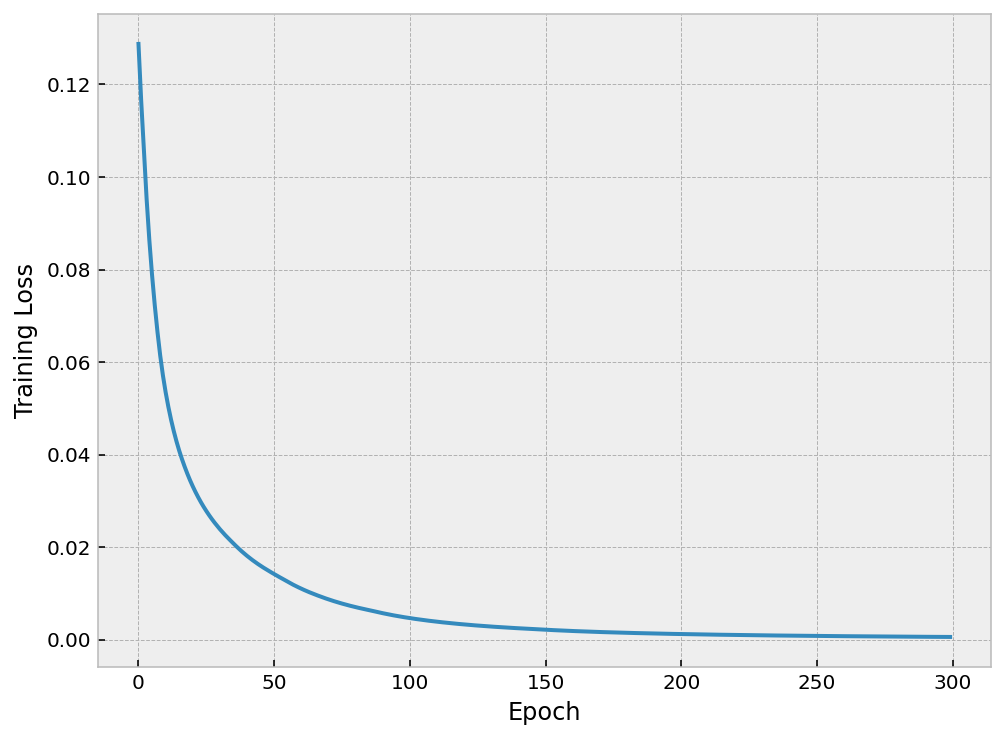

In [77]:
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss');

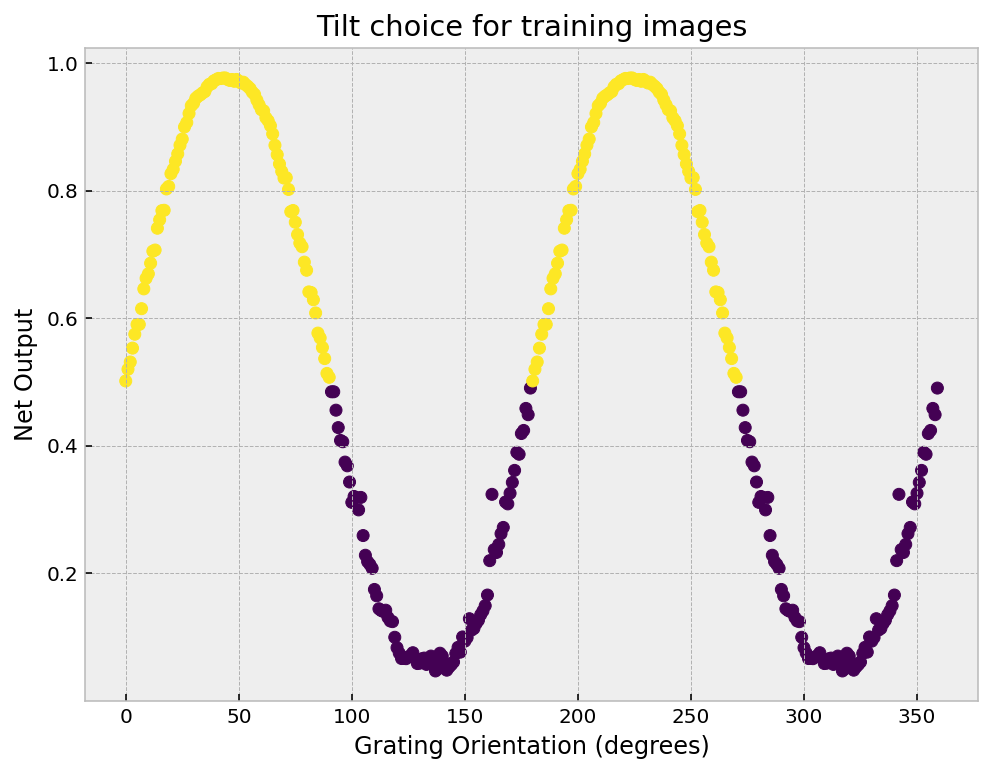

In [82]:
y_pred = model(stimuli)

y_pred = y_pred.squeeze().detach()

choice = (y_pred >= 0.5)

plt.scatter(orientations, y_pred, c=choice)
plt.xlabel('Grating Orientation (degrees)')
plt.ylabel('Net Output')
plt.title('Tilt choice for training images');

In [91]:
test_orientations = np.random.random(1000) * 360

test_orientations[:5]

array([ 52.49073214,  18.98482415, 182.08369152, 108.56141942,
       186.05945977])

In [92]:
test_stimuli = torch.zeros((len(test_orientations), 1, 48, 64), dtype=torch.float32)
for i, ori in enumerate(test_orientations):
    test_stimuli[i,0,:,:] = make_grating(ori)

test_stimuli.shape

torch.Size([1000, 1, 48, 64])

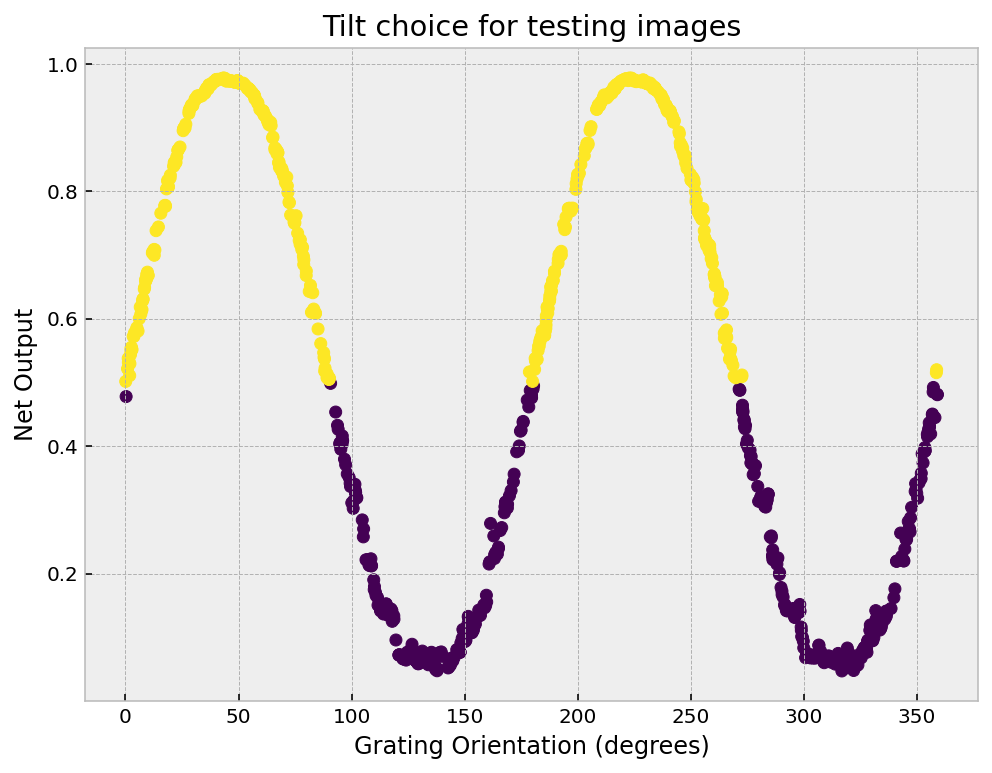

In [93]:
y_pred = model(test_stimuli)

y_pred = y_pred.squeeze().detach()

choice = (y_pred >= 0.5)

plt.scatter(test_orientations, y_pred, c=choice)
plt.xlabel('Grating Orientation (degrees)')
plt.ylabel('Net Output')
plt.title('Tilt choice for testing images');

In [94]:
model.conv.weight.shape

torch.Size([6, 1, 7, 7])

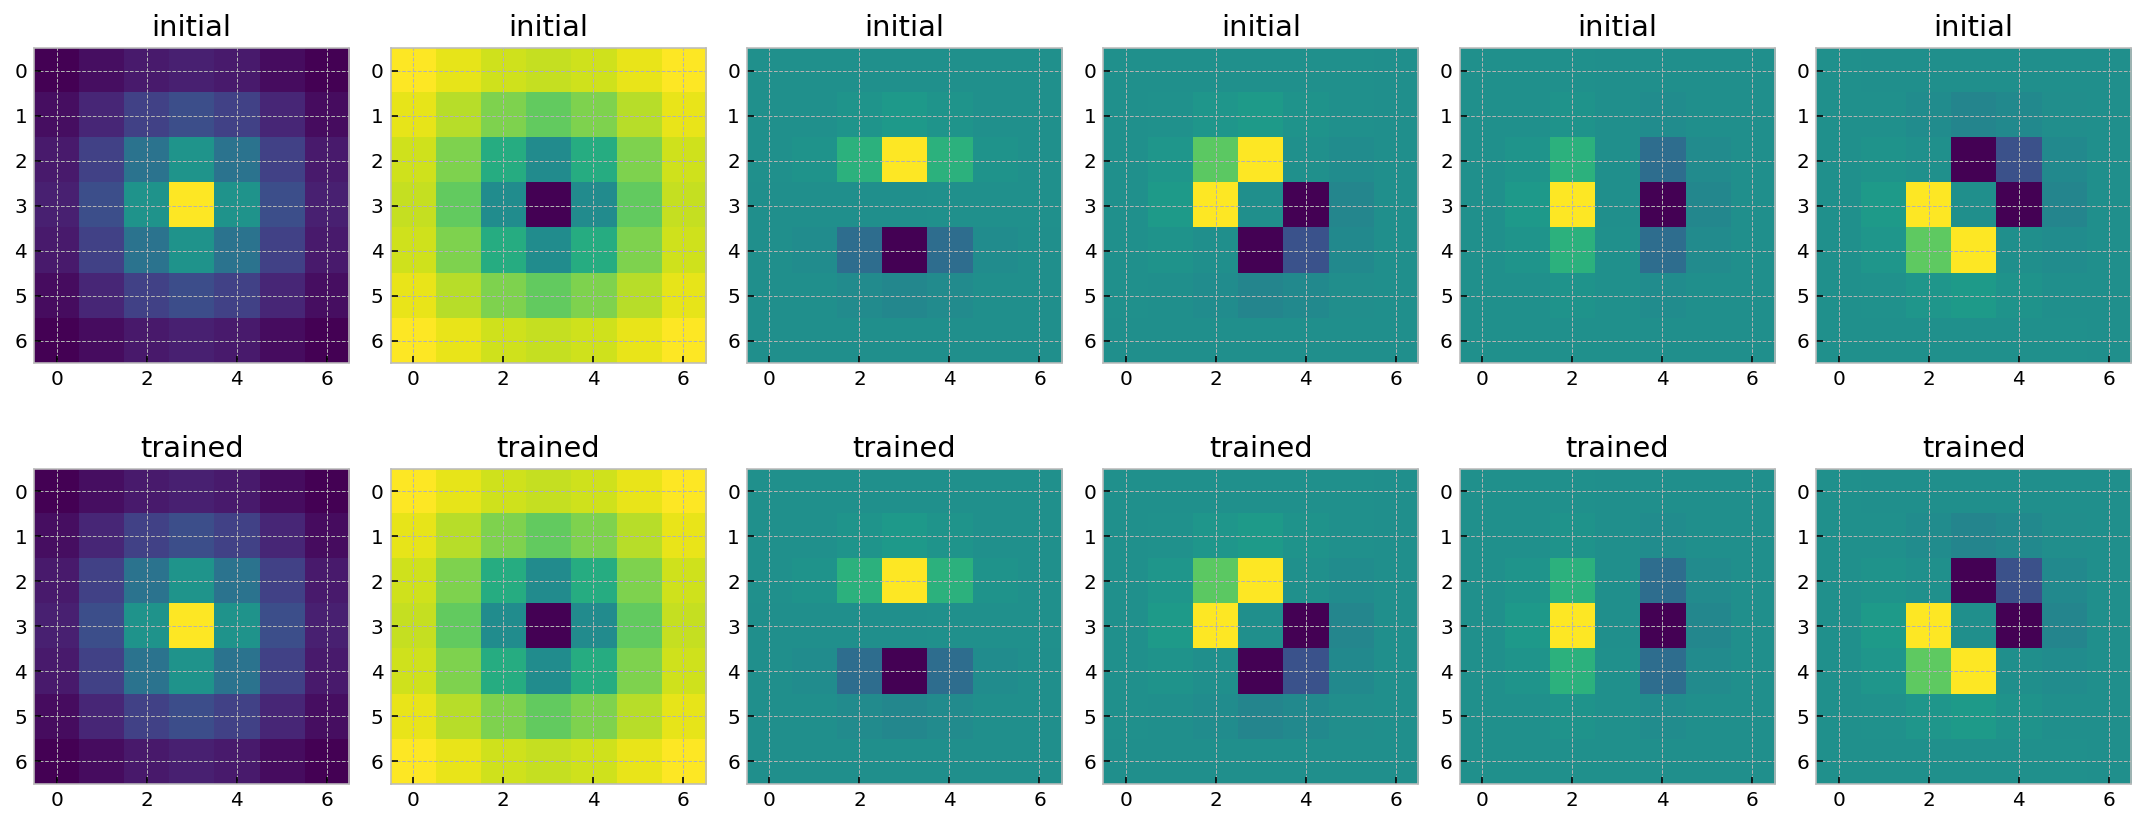

In [95]:
trained_filters = model.conv.weight.detach()

plt.figure(figsize=[15,6])
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(filters[i,0,:,:])
    plt.title('initial')
for i in range(6):
    plt.subplot(2, 6, i+7)
    plt.imshow(trained_filters[i,0,:,:])
    plt.title('trained')
plt.tight_layout()